In [1]:
import os
import json

import numpy as np
from scipy.ndimage.interpolation import shift
from PIL import Image

from tools.pokeplot import plot_multiple_images

# Image processing

In [2]:
images = []
shifts = ([0,1], [0,-1], [1,0], [-1,0])

dataset="pokemon_bw_alpha_eyes_2"
#dataset="pokemon_bw_alpha_shape/wings"

for filename in os.listdir(dataset):
    file_path = dataset + "/" + filename
    image = Image.open(file_path).convert('L')
    images += [np.repeat(np.repeat(np.array(image), 2, axis=0), 2, axis=1)]
    for s in shifts:
        images += [shift(np.repeat(np.repeat(np.array(image), 2, axis=0), 2, axis=1), shift=s, cval=.0)]

images = np.array(images)
images = images.astype(np.float32) / 255
images = images.reshape(images.shape[0], 72*2, 72*2, 1)

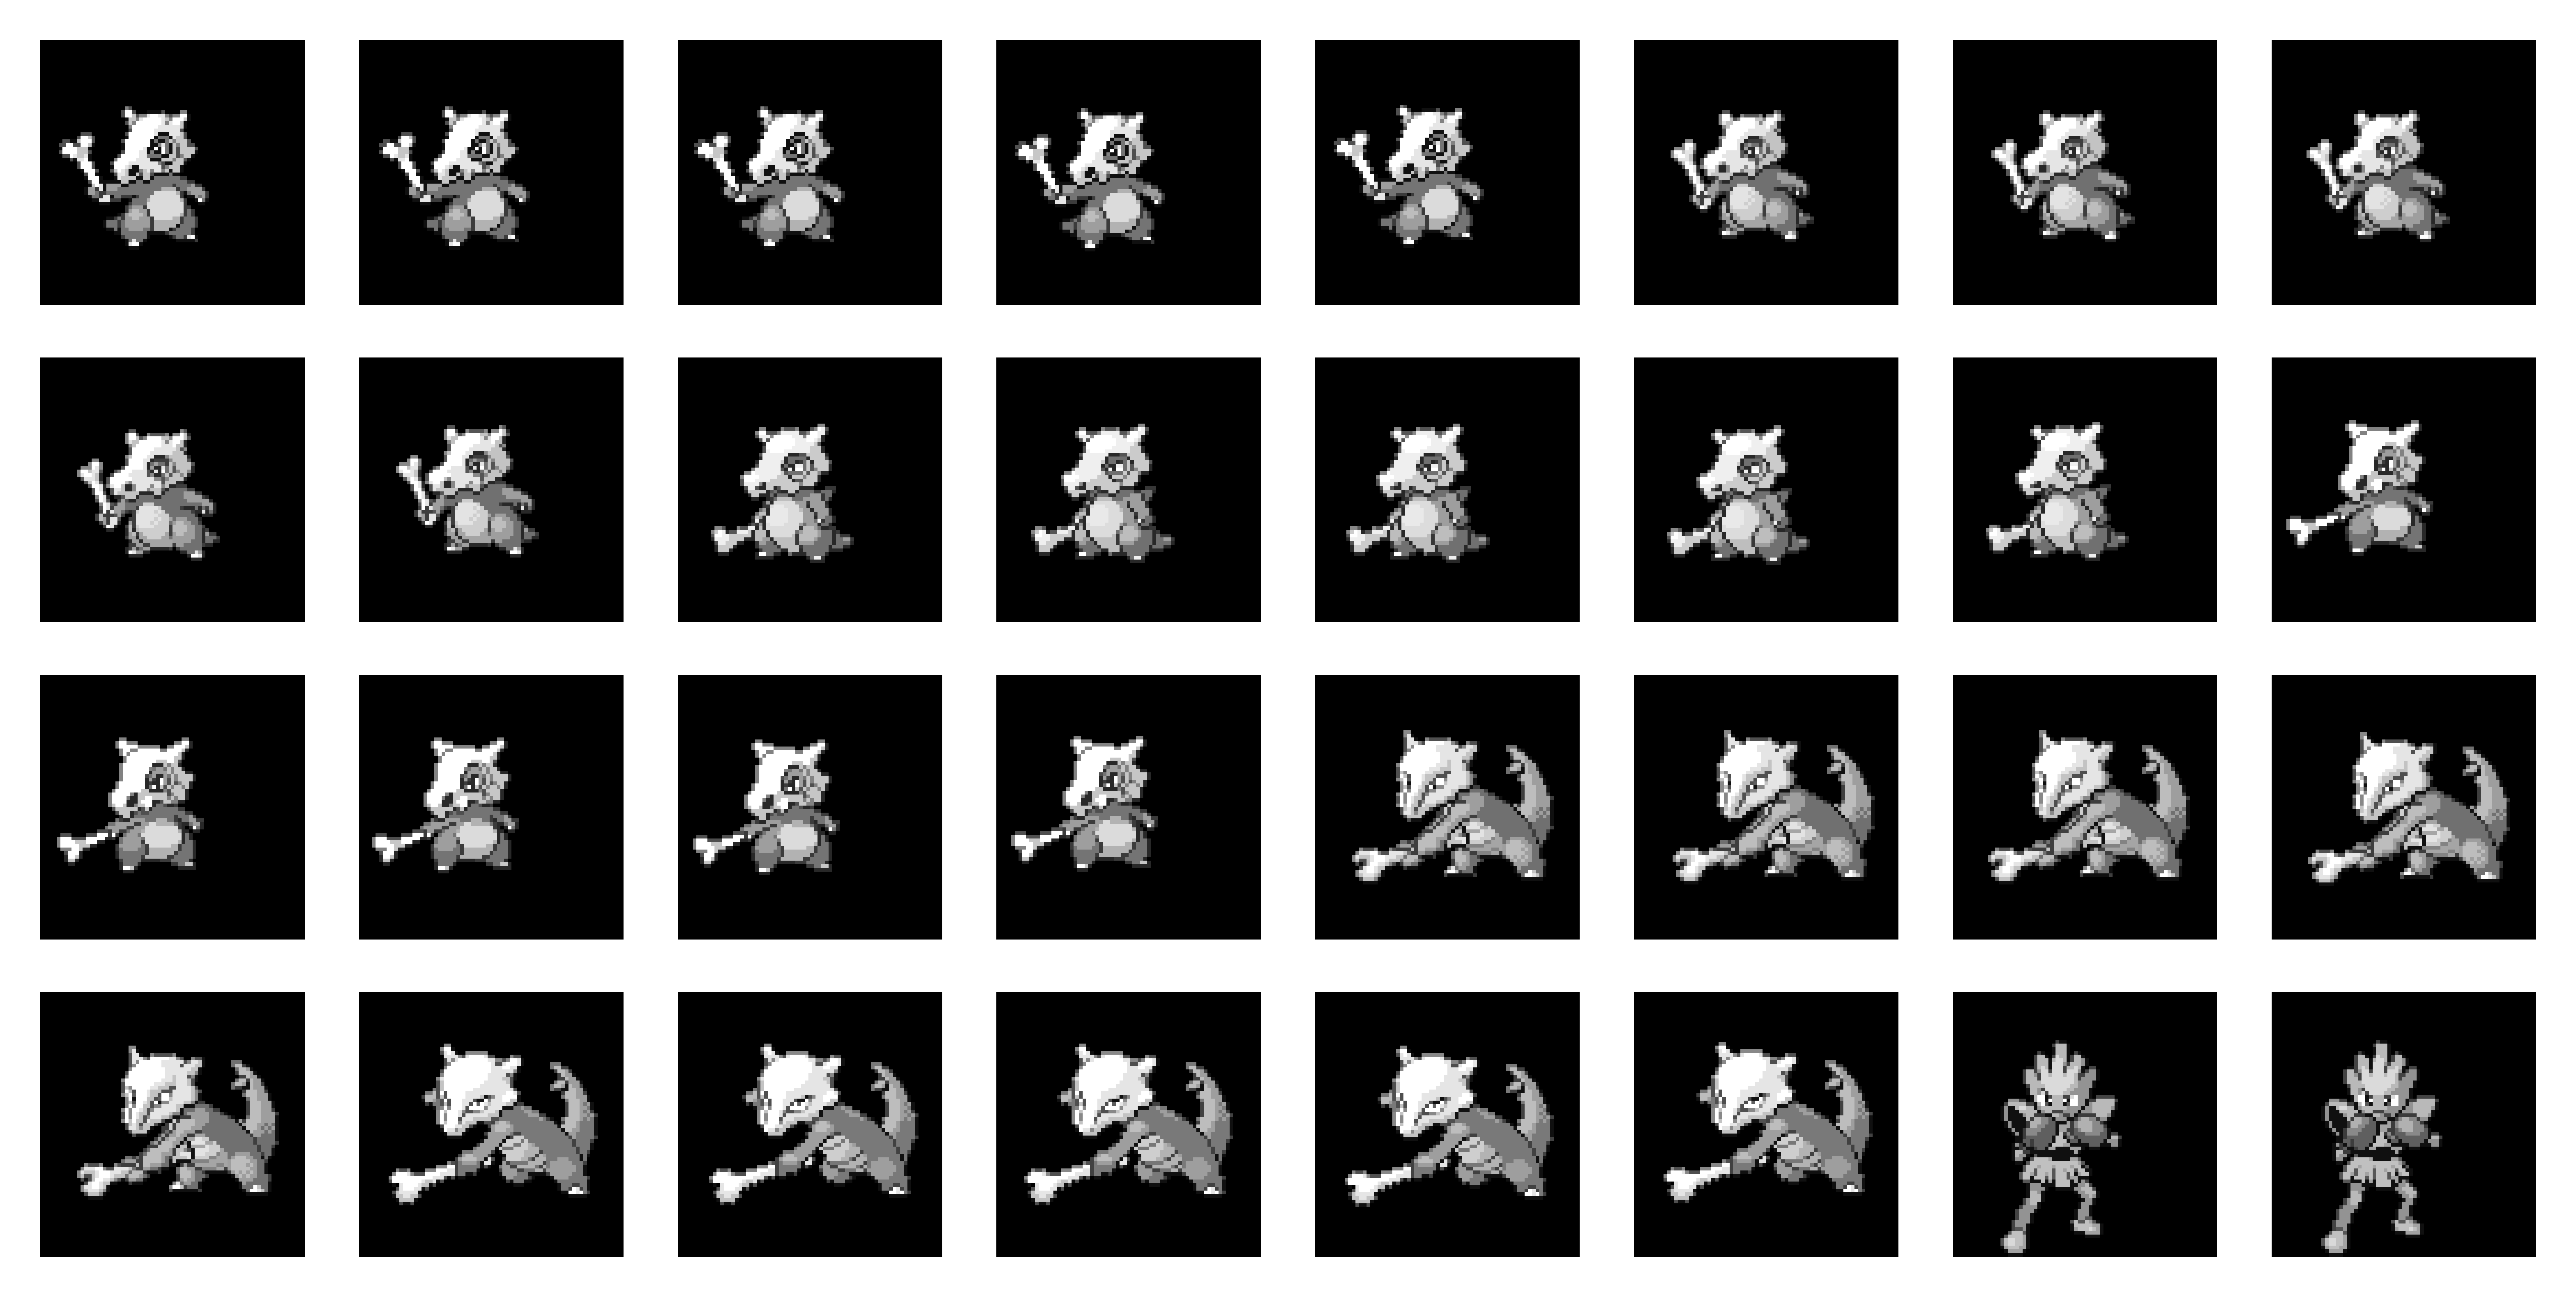

In [3]:
plot_multiple_images(images[:32].reshape(32,72*2,72*2),8)

# DCGAN

In [4]:
from models.generator import Generator
from models.discriminator import Discriminator
from models.preprocessor import Preprocessor

from tools.training import train_gan

from tensorflow import keras, optimizers

In [5]:
k_size = 5
codings_size = 200
batch_size = 8

gen = {"dense": {"pixels":18,
                 "channels":64,
                 "batchnorm":True
                },
       "conv2dts": {"c1": {"channels":64,
                           "kernel_size":k_size,
                           "strides":2,
                           "batchnorm":False,
                           "dropout":False,
                           "dropout_rate":0.5
                          },
                    "c2": {"channels":16,
                           "kernel_size":k_size,
                           "strides":2,
                           "batchnorm":False,
                           "dropout":False,
                           "dropout_rate":0.5
                          },
                    "c3": {"channels":4,
                           "kernel_size":k_size,
                           "strides":2,
                           "batchnorm":False,
                           "dropout":False,
                           "dropout_rate":0.5
                          }
                   },
       "conv2dt_out": {"kernel_size":k_size,
                       "strides":1}
      }

In [6]:
disc = {"conv2d_in": {"channels":128,
                      "kernel_size":k_size,
                      "strides":2,
                      "batchnorm":False,
                      "dropout":True,
                      "dropout_rate":0.2
                },
        "conv2ds": {"c1": {"channels":128,
                           "kernel_size":k_size,
                           "strides":2,
                           "batchnorm":False,
                           "dropout":True,
                           "dropout_rate":0.2
                          },
                    "c2": {"channels":256,
                           "kernel_size":k_size,
                           "strides":2,
                           "batchnorm":False,
                           "dropout":True,
                           "dropout_rate":0.2
                          },
                    "c3": {"channels":256,
                           "kernel_size":k_size,
                           "strides":1,
                           "batchnorm":False,
                           "dropout":False,
                           "dropout_rate":0.5
                          }
                   }
       }

In [7]:
generator_dcgan = Generator(gen, codings_size)
discriminator_dcgan = Discriminator(disc, 144)
preprocess_dcgan = Preprocessor({"random_flip":True,
                                 "random_contrast":False})
dcgan = keras.models.Sequential([generator_dcgan, discriminator_dcgan])

In [8]:
generator_dcgan.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20736)             4167936   
_________________________________________________________________
reshape (Reshape)            (None, 18, 18, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 64)        256       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 36, 36, 64)        102464    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 72, 72, 16)        25616     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 144, 144, 4)       1604      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 144, 144, 1)       10

In [9]:
discriminator_dcgan.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 72, 72, 128)       3328      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 128)       409728    
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 256)       819456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 256)       1638656   
_________________________________________________________________
flatten (Flatten)            (None, 82944)           

In [10]:
g_loss = "binary_crossentropy"
g_lr = (10**-4)
d_loss = "binary_crossentropy"
d_lr = (10**-4)

discriminator_dcgan.trainable = True
discriminator_dcgan.compile(loss=d_loss, optimizer=optimizers.Adam(learning_rate=d_lr))
discriminator_dcgan.trainable = False
dcgan.compile(loss=g_loss, optimizer=optimizers.Adam(learning_rate=g_lr))

In [11]:
num_GAN = 0

params = {"dataset" : dataset,
          "codings_size" : codings_size,
          "batch_size" : batch_size,
          "d_loss": d_loss,
          "g_loss": g_loss,
          "d_optimizer": "Adam",
          "d_lr": d_lr,
          "g_optimizer": "Adam",
          "g_lr": g_lr,
          "preprocess": [l.get_config() for l in preprocess_dcgan.layers]}

with open("./DCGAN_{}/params/params.json".format(num_GAN), "w") as fp:
    json.dump(params, fp)

In [ ]:
train_gan(dcgan, preprocess_dcgan, num_GAN, images,
          batch_size, codings_size,
          learning_ratio=1, n_epochs=5000, resume_training_at_epoch=0,
          images_saving_ratio=1, model_saving_ratio=1, verbose=True)

------------------------------------ Epoch 1/5000 ------------------------------------
